# Neural Networks for Data Science Applications (2019/2020)
## Final exam

* **Student**: Leandro Bernardino Gentili (1527999).
* **Reference paper**: Ronneberger, Olaf; Fischer, Philipp; Brox, Thomas (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation [\[arXiv:1505.04597\]](https://arxiv.org/pdf/1505.04597.pdf)



## Part 1: Report

### Overview
When it comes to work with deep neural networks there is a huge need of good quality labeled data but, depending on the field of interest, it is not always easy to obtain a considerable amount of it as well as other difficulties could come up (ex. processing high-dimensional data). On that note, **Biomedical Image Segmentation** seems to perfectly fit the description above, as it consist in building a model capable of automatically partitioning an image into subset of pixels, assigning a class, in order to recognize a precise pattern (ex. cells tracking).

This is a non-trivial task and, of course, it would be beneficial to have the following:
* to have a fast NN architecture to process highly-dimensional data such as images
* to find a way to exploit a small set of images making it more valuable
* to maintain context (what) and localization (where) assigning a class to each pixel whereas in a general image classification task localization could not be so relevant

### U-Net in a nutshell
![U-Net architecture from the original paper](../assets/u-net-architecture.png)

This novel U-shaped architecture was presented by *O.Ronneberger et al.* in 2015 to be first used in the biomedical field. The authors were able to provide a fast GPU-enabled **fully-connected Convolutional Neural Network** which yields more precise segmentations (with both context and localization) along with a training strategy merely based on strong data augmentation. The latter consists in creating a continuous flow of data from a small set whilst applying some **data trasformations** such as zoom, elastic deformations, rotations and so on. 

Briefly, U-Net consists of *three* parts:
* The *contracting path*, **encoder**, on the left which enables to capture context ("what" is it). This is pretty common and straightforward in CNNs.
* The *bottleneck* at the center, better explained later.
* The *expanding path*, **decoder**, on the right which enables to localize ("where" is the "what"). 

### About this experiment
For the sake of this project, we will implement the U-Net model using **Keras/TF 2.1** and then we will apply it to the official dataset from the [ISBI 2012 challenge](http://brainiac2.mit.edu/isbi_challenge/), segmentation of neuronal structures in EM stacks.
The training data is a set of 30 (512x512) items coming from electron microscopy images of the *Drosophila first instar larva ventral nerve cord* (VNC). Each item is provided with a segmentation map (label) where cells are white and membranes are black. 
Clearly, this is a **binary classification** task, hence a different output layer will be used along with a different energy function, loss, and optimizer. In fact, we will make use of **sigmoid** as our energy function since we could represent our output as a probability distribution between 0 and 1:

$S(z) = \frac{1} {1 + e^{-z}}$ 

We will evaluate our predictions through **binary-crossentropy** loss, defined as follows:

$BCE = -{(y\log(p) + (1 - y)\log(1 - p))}$

where $p$ is the probability of being a membrane and $1 - p$ the chance to be a cell.

The typical behaviour of a log-loss is to penalize as much as possible depending on how much wrong is the prediction; otherwise, it will be close to or equal to zero. As our optimizer, we will use **Adam**, a momentum-based optimizer, which works really well in noisy contexts. Finally, we will implement two useful **traning callbacks**: *EarlyStopping* and *ReduceLROnPlateau*. They basically will help us in updating the learning rate or stop traning whether our network stops learning.

Obviously, due to the small training set, we will make use **data augmentation** techniques which TF and Keras make less painful than ever. Any other minor details about the implementation will be briefly discussed as comments within the code.

## Part 2: Environment set up

Firstly, we have to set up our environment installing some required libraries (not too many). Also, **DO NOT** foget to install *git-lfs* to retrieve big files from GitHub (our pre-trained weights and dataset)!

### Imports

In [1]:
# some useful features 
%load_ext autoreload
%autoreload 2    
%matplotlib inline

# suppress TF Warnings 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from model import UNet
from data import EMData
from utils import Iterator, Images

Before starting the experiment, we define some useful *global* variables:

In [2]:
# dataset
DATASET_PATH = './data'
TEST_DATA_PATH = DATASET_PATH + '/test/img'
TRAIN_DATA_PATH = DATASET_PATH + '/train/img'
LABELS_DATA_PATH = DATASET_PATH + '/labels/img'

# input
COLOR_MODE = {'grayscale': 1, 'rgb': 3, 'rgba': 4} # channels
IMG_COLOR_MODE = COLOR_MODE['grayscale']
IMG_W_H = (512, 512)
INPUT_SHAPE = (IMG_W_H[0], IMG_W_H[1], IMG_COLOR_MODE)

# output
OUTPUT_SHAPE = 1
EPOCHS = 10
STEPS_PER_EPOCH = 500
VALIDATION_SPLIT = 0.2 # 20% of the traning data

## Part 3 - EM segmentation (ISBI 2012)

Now, we need to retrieve the official ISBI dataset for their website but, unfortunately, it is not available without any registration (since they assume we would join the competition, but we are not). That's why there is a *em-segmentation.zip* file inside the data folder which contains the previously mentioned dataset as-it-is.

Overall, the dataset is comprised of 3 *.tif* stacks (train, labels, test), each of those containing 30 frames. To make things easier, we will use a python class created for this purpose... we just need to unzip the compressed archive.

In [3]:
#!unzip ./data/pre_trained.zip -d ./data/pre_trained
#!unzip ./data/em_segmentation.zip -d ./data/em_segmentation

Briefly, *EMData* class will do the following:
* checking current files and folders
* creating the correct folders structure
* extracting all the frames from each .tiff stack, in another format if necessary (ex. png)

In [3]:
emdata = EMData(data_path=DATASET_PATH)

# NOTE: if data is already in place, we mush use overwrite=True
emdata.unpack(save_as='.png', overwrite=True)

Extracting no. 30 frames from train-volume.tif
Extracting no. 30 frames from train-labels.tif
Extracting no. 30 frames from test-volume.tif


We can now have a look at some traning samples.

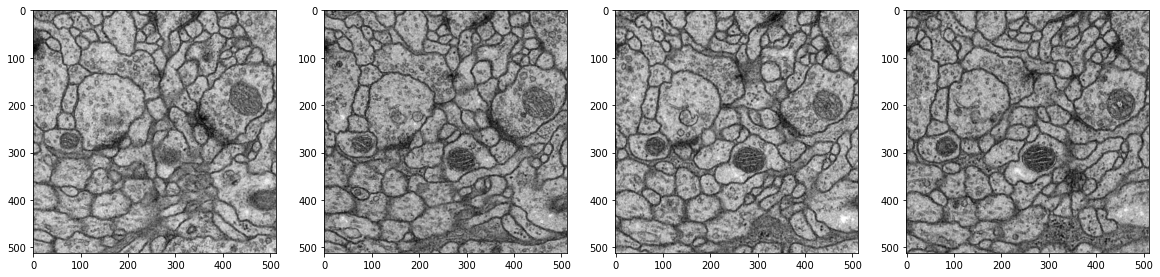

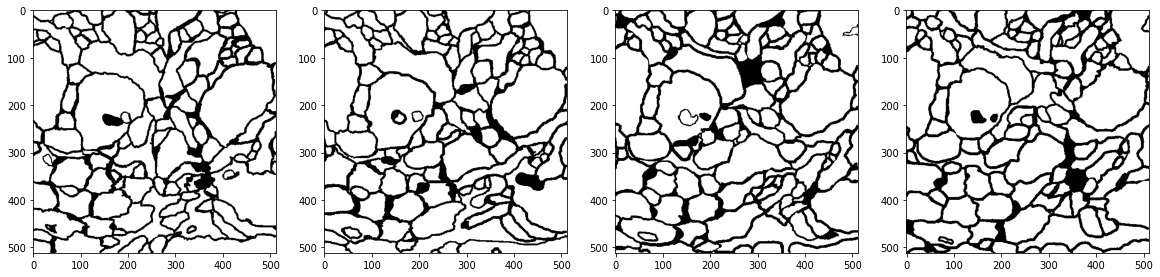

In [5]:
Images.plot_imgs_from_folder(TRAIN_DATA_PATH, n_max=4, cols=4, cmap='gray', figsize=(20, 50))
Images.plot_imgs_from_folder(LABELS_DATA_PATH, n_max=4, cols=4, cmap='gray', figsize=(20, 50))

In [6]:
# init model
unet = UNet(INPUT_SHAPE, OUTPUT_SHAPE)

# show a summary of our model
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Let's plot training history in order to infer something about the behaviour of our model:

In [7]:
# to save weights
#unet_k.save_weights('./my_weights.h5')

# to restore weights from any checkpoint folder (last will be loaded)
#unet.load_weights('./checkpoints', checkpoint=True)

# to restore weights single file
unet.load_weights('./data/pre_trained/pre_trained.h5')

As said before, we do not have any test labels and that's why we are going to use them for the prediction phase.

In [19]:
# load Test images from folder...
#test_data = Iterator.imgs_from_folder(directory=TEST_DATA_PATH, normalize=True, output_shape=(1, 512, 512, 1))
test_data = Iterator.imgs_from_folder(directory="/Users/legent/Downloads/test_data", normalize=True, output_shape=(1, 512, 512, 1))

In [20]:
# ... and predict!
preds = unet.predict(test_data, verbose=1)

# Optionally, we can set a threshold to have both version of the data
#preds, binary_preds = unet.predict(test_data, threshold=0.5, verbose=1)

Providing image [[[[0.348]
   [0.36 ]
   [0.388]
   ...
   [0.232]
   [0.284]
   [0.312]]

  [[0.324]
   [0.34 ]
   [0.376]
   ...
   [0.308]
   [0.344]
   [0.364]]

  [[0.272]
   [0.3  ]
   [0.348]
   ...
   [0.456]
   [0.464]
   [0.468]]

  ...

  [[0.512]
   [0.504]
   [0.488]
   ...
   [0.508]
   [0.552]
   [0.576]]

  [[0.492]
   [0.48 ]
   [0.456]
   ...
   [0.528]
   [0.58 ]
   [0.604]]

  [[0.48 ]
   [0.468]
   [0.44 ]
   ...
   [0.54 ]
   [0.592]
   [0.62 ]]]]
1/1 [==============================] - 1s 1s/step


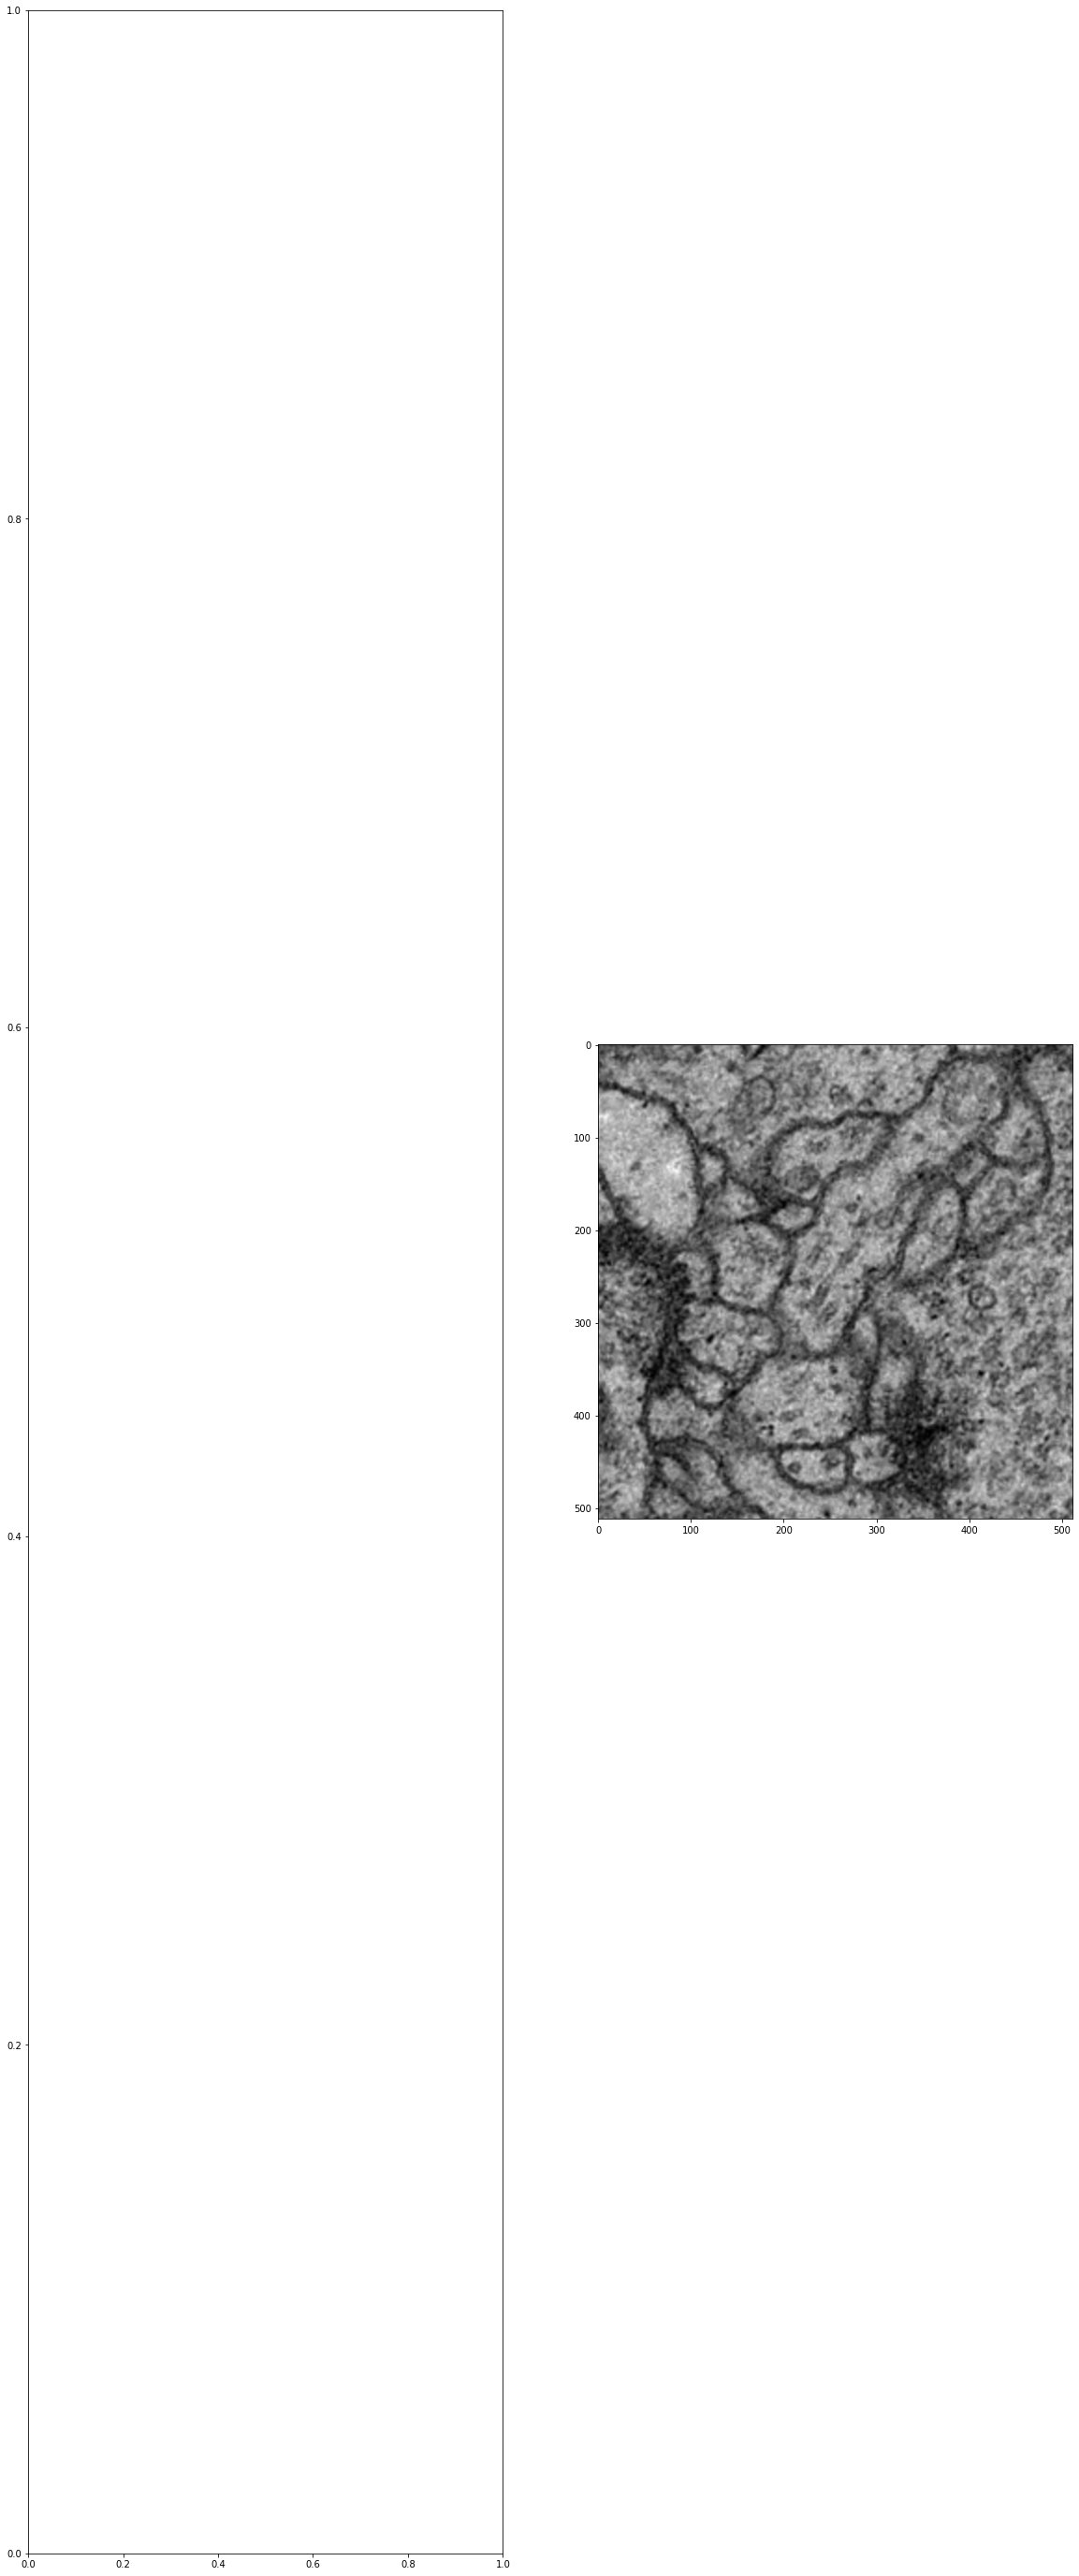

IndexError: index 1 is out of bounds for axis 0 with size 1

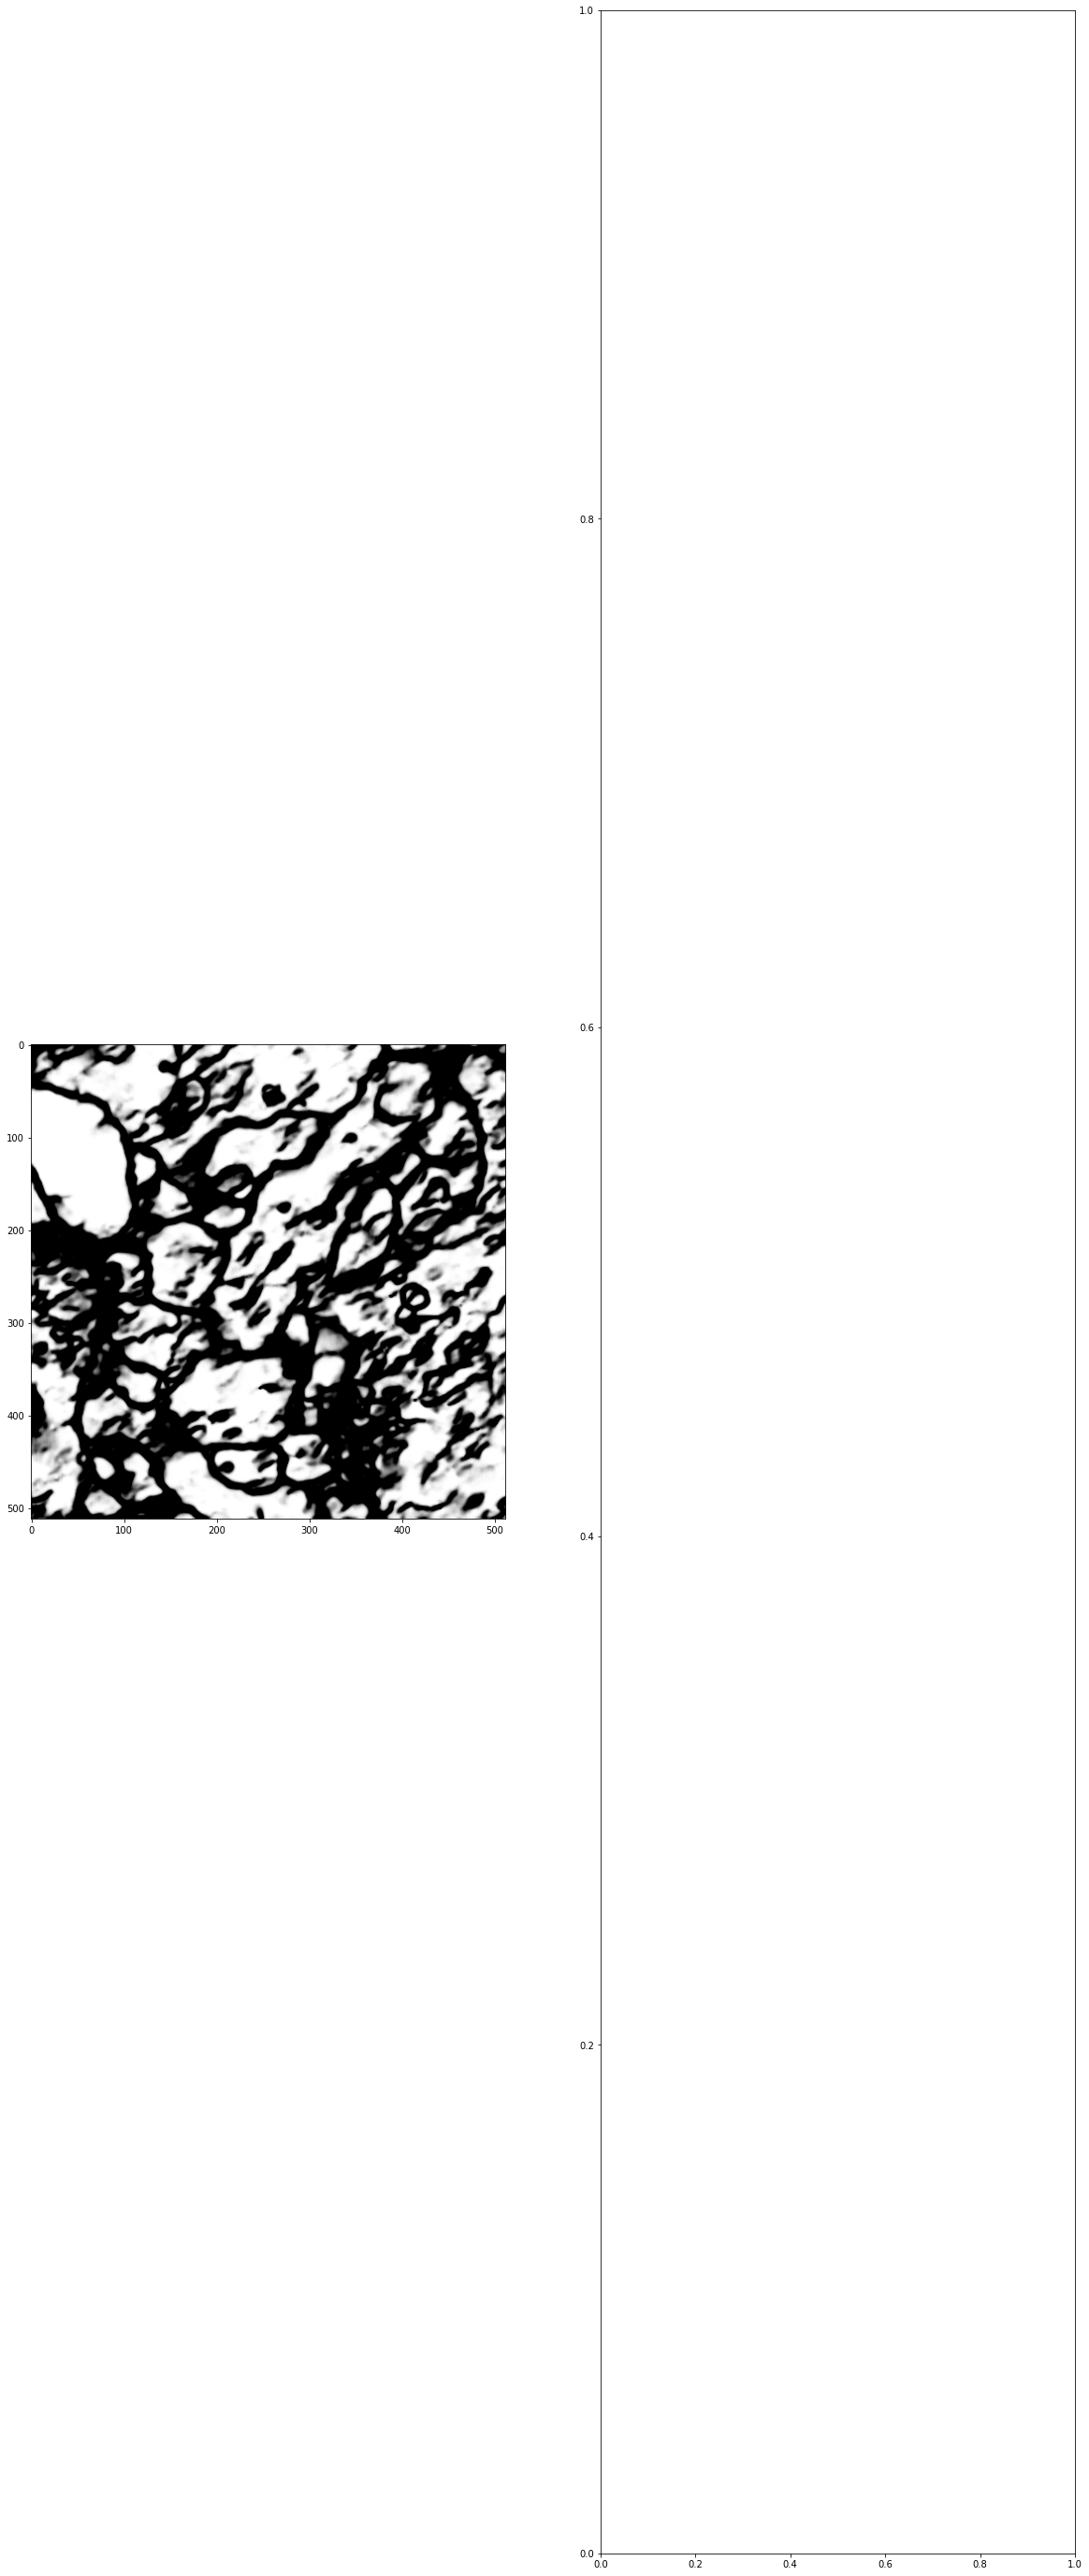

In [23]:
# plot some test data with their predictions 
Images.plot_imgs_from_folder("/Users/legent/Downloads/test_data", n_max=5, cols=2, cmap='gray', figsize=(20, 50))
Images.plot_arr_to_imgs(preds, n_max=5, cols=2, cmap='gray', figsize=(20, 50))

The results are promising! We're quite sure it will be possible to enhance these results playing with data augmentation (ex. other shades of gray) or with hyper-parameters of our network.